In [1]:
NEED_TO_INSTALL_PACKAGES = True
if NEED_TO_INSTALL_PACKAGES:
    !pip install tensorboard psutil gwpy lalsuite bilby>=2.1.2
    !pip install swyft
    !pip install torch

## SIMULATION-BASED EXAMPLE

In [2]:
import swyft.lightning as sl
import torch
import numpy as np
import matplotlib.pyplot as plt
import bilby

In [3]:
injection_parameters = dict(m=0.5, c=0.2)


time_duration = 10
sampling_frequency = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
sigma = np.random.normal(1, 0.01, N)

model_parameters = dict(
        sampling_frequency = sampling_frequency,
        time_duration = time_duration,
        time = time,
        N = N,
        sigma = sigma,)

priors = dict()
priors["m"] = bilby.core.prior.Uniform(0, 10, "m")
priors["c"] = bilby.core.prior.Uniform(-5, 5, "c")

In [4]:
class Simulator(sl.Simulator):
    def __init__(self, model_parameters):
        super().__init__()
        self.model_parameters = model_parameters
        self.priors = priors

    def sample_priors(self):
        params = np.array([self.priors[p].sample() for p in self.priors])
        return params

    def model(self,params):
        param_dict = dict(zip(self.priors.keys(), params))
        signal = self.model_parameters['time'] * param_dict['m'] + param_dict['c']
        return signal

    def noise(self):
        noise = np.random.normal(0, self.model_parameters['sigma'], self.model_parameters['N'])
        return noise

    def build(self,graph):
        params = graph.node('params', self.sample_priors)
        signal = graph.node('signal', self.model, params)
        noise = graph.node('noise', self.noise)

In [5]:
sim = Simulator(model_parameters)

In [6]:
shapes, dtypes = sim.get_shapes_and_dtypes()
store = sl.ZarrStore("store_regression")
store.init(
    N = 5_000,
    chunk_size=1000,
    shapes=shapes,
    dtypes=dtypes,
)

In [7]:
store.sims_required

0

In [8]:
store.simulate(sim, batch_size=1000)

In [9]:
print(store.keys())
print(store['signal'].shape)
print(store['params'].shape)

['noise', 'params', 'signal']
(5000, 100)
(5000, 2)


In [10]:
class Network(sl.SwyftModule):
    def __init__(self):
        super().__init__()
        self.embedding_network = torch.nn.LazyLinear(32)
        self.activation = torch.nn.ReLU()
        self.logratios_1d = sl.LogRatioEstimator_1dim(num_features=32, num_params=2, varnames='params', hidden_features=16)
        self.logratios_2d = sl.LogRatioEstimator_Ndim(num_features=32, marginals=((0, 1),), varnames='params', hidden_features=16)
        self.optimizer_init = sl. AdamW()
        self.batch_size = 64

    def forward(self, A, B):
        signal = A['signal']
        noise_shuffling = torch.randperm(signal.shape[0])
        data = A['signal'] + A['noise'][noise_shuffling]
        params = B['params']
        data = self.embedding_network(data)
        data = self.activation(data)
        logratios_1d = self.logratios_1d(data, params)
        logratios_2d = self.logratios_2d(data, params)
        return logratios_1d, logratios_2d

In [11]:
network = Network()

In [12]:
train_data = store.get_dataloader(
    num_workers=2,
    batch_size=64,
    idx_range=[0, 4500],
)

val_data = store.get_dataloader(
    num_workers=2,
    batch_size=64,
    idx_range=[4500, 5000],
)

In [13]:
trainer = sl.SwyftTrainer(accelerator = 'cpu', precision=64, min_epochs=5, max_epochs=50)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
### TRAIN THE NETWORK
trainer.fit(network, train_data, val_data)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/home/naga203/anaconda3/envs/grav/lib/python3.11/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:411: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name              | Type                   | Params
-------------------------------------------------------------
0 | embedding_network | LazyLinear             | 0     
1 | activation        | ReLU                   | 0     
2 | logratios_1d      | LogRatioEstimator_1dim | 3.6 K 
3 | logratios_2d      | LogRatioEstimator_Ndim | 1.8 K 
-------------------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.043     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/naga203/anaconda3/envs/grav/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/naga203/anaconda3/envs/grav/lib/python3.11/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
/home/naga203/anaconda3/envs/grav/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /home/naga203/grav_waves/nikhef/tutorial_notebooks/lightning_logs/version_2/checkpoints/epoch=9-step=770.ckpt


/home/naga203/anaconda3/envs/grav/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.best_

In [15]:
prior_samples = sim.sample(100_000, targets=['params'])

  0%|          | 0/100000 [00:00<?, ?it/s]

In [16]:
obs_signal = sim.model([injection_parameters['m'], injection_parameters['c']])
obs_noise = sim.noise()

obs = sl.Sample(
    {'params' : np.array([injection_parameters['m'], injection_parameters['c']]),
     'noise' : obs_noise,
     'signal' : obs_signal,
     }
)

In [17]:
logratios = trainer.infer(network, obs, prior_samples.get_dataloader(batch_size=2048))

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 77it [00:00, ?it/s]

/home/naga203/anaconda3/envs/grav/lib/python3.11/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


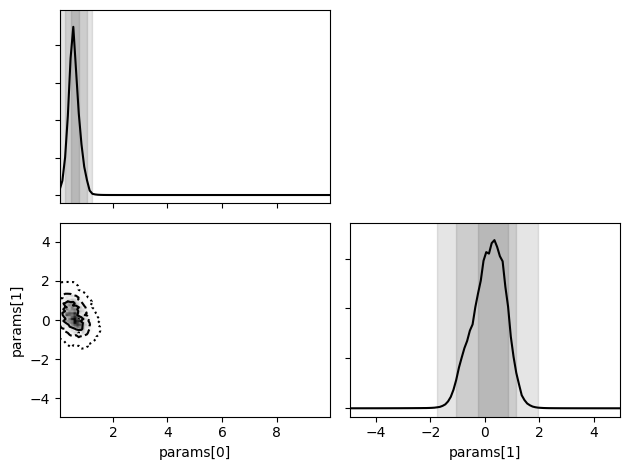

In [18]:
sl.swyft.plot_corner(logratios, parnames=["params[0]", "params[1]"]);

## LIKELIHOOD-BASED EXAMPLE

In [19]:
time = np.arange(0, time_duration, 1 / sampling_frequency)
sigma = np.random.normal(1, 0.01, N)

model_parameters = dict(
        sampling_frequency = 10,
        time_duration = 10,
        time = time,
        N = len(time),
        sigma = sigma,)

priors = dict()
priors["m"] = bilby.core.prior.Uniform(0, 10, "m")
priors["c"] = bilby.core.prior.Uniform(-5, 5, "c")

In [20]:
# A few simple setup steps
label = "linear_regression"
outdir = "outdir_bilby"
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)

In [21]:
# First, we define our "signal model", in this case a simple linear function
def model(time, m, c):
    return time * m + c

def noise(sigma, N):
    noise = np.random.normal(0, sigma, N)
    return noise

In [22]:
# Now we define the injection parameters which we make simulated data with
injection_parameters = dict(m=0.5, c=0.2)

sampling_frequency = 10
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
sigma = np.random.normal(1, 0.01, N)

In [23]:
signal = model(model_parameters['time'], **injection_parameters)
noise = noise(model_parameters['sigma'], model_parameters['N'])
data = signal + noise

Text(0, 0.5, 'Signal amplitude')

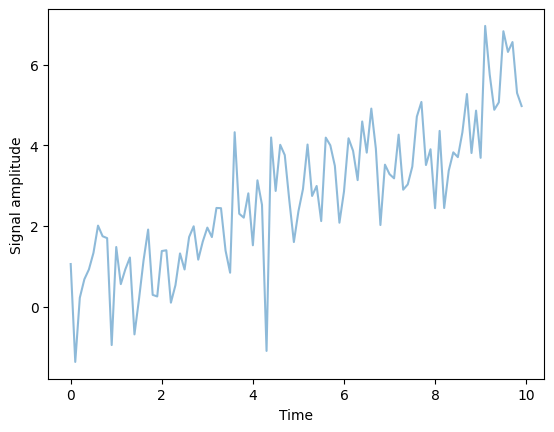

In [24]:
# plt.plot(time, signal)
plt.plot(model_parameters['time'], data, alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Signal amplitude")

In [25]:
# From hereon, the syntax is exactly equivalent to other bilby examples
# We make a prior
priors = dict()
priors["m"] = bilby.core.prior.Uniform(0, 10, "m")
priors["c"] = bilby.core.prior.Uniform(-5, 5, "c")

In [26]:
# Now lets instantiate a version of our GaussianLikelihood, giving it
# the time, data and signal model
likelihood = bilby.likelihood.GaussianLikelihood(model_parameters['time'], data, model, sigma)

14:31 bilby INFO    : Running for label 'linear_regression', output will be saved to 'outdir_bilby'
14:31 bilby INFO    : Analysis priors:
14:31 bilby INFO    : m=Uniform(minimum=0, maximum=10, name='m', latex_label='m', unit=None, boundary=None)
14:31 bilby INFO    : c=Uniform(minimum=-5, maximum=5, name='c', latex_label='c', unit=None, boundary=None)
14:31 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
14:31 bilby INFO    : Analysis likelihood noise evidence: nan
14:31 bilby INFO    : Single likelihood evaluation took 9.933e-05 s
14:31 bilby INFO    : Checkpoint every check_point_delta_t = 600s
14:31 bilby WARNING : Using cached result
14:31 bilby INFO    : Summary of results:
nsamples: 686
ln_noise_evidence:    nan
ln_evidence: -153.098 +/-  0.210
ln_bayes_factor:    nan +/-  0.210



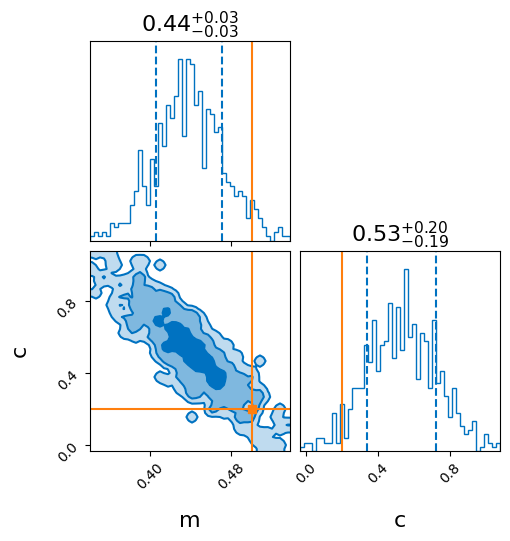

In [27]:
# And run sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=250,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
)

# Finally plot a corner plot: all outputs are stored in outdir
result.plot_corner()
